# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# библиотеки можно импортировать сразу, а можно и по ходу анализа. 
# Выберем первый вараинт.
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# загрузим файл /datasets/real_estate_data.csv. Мы знаем, что сепаратором является обратный слеш. Поэтому добавим его сразу.

try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

# и посотрим, что загрузилось:

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# посмотрим, размеры датасета и общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

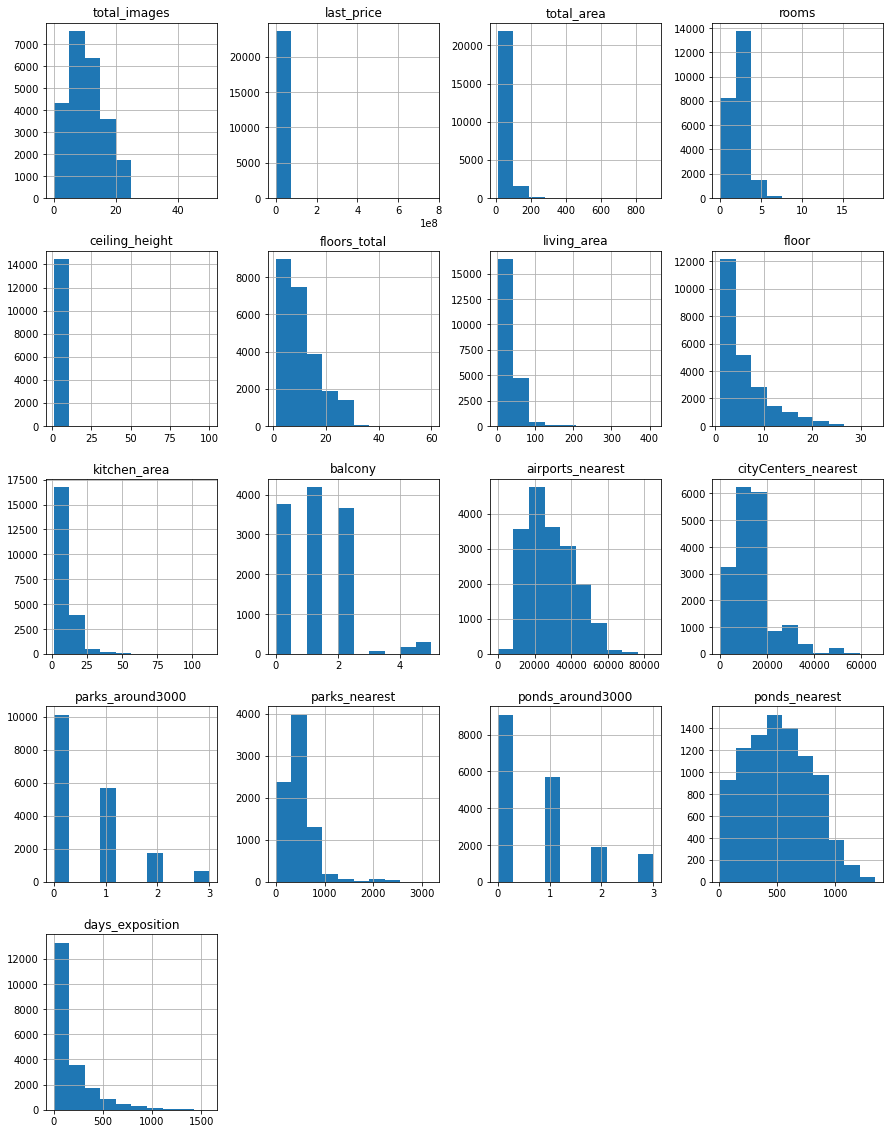

In [4]:
# сделаем гистограммы в "сыром" датасете. Так рекомендуют в задании :)

data.hist(figsize=(15, 20));

Выводы:
Посмотрели, что таблица значительная и должна быть интересная. Во многих таблицах заполнены не все данные. Также видно, что типы данных несоответсвтуют как логическим, так и описанию.

### Предобработка данных

In [5]:
# попробуем посмотреть названия столбцов. Приведем их к единому формату.
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [6]:
# в глаза бросается 'cityCenters_nearest', который написан на "верблюжем" языке. Переведем на "змеиный".
# Значений не много. Поэтому можно сделать это вручную

data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("cityCenters_nearest", "city_centers_nearest")

In [7]:
# посмотрим на пропуски в значениях каждого столбца:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
# доля пропусков с градиентом. Прям как в Excel =)
pd.DataFrame(round(data.isna().mean()*100, 1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Пропуски есть. И их достаточно много. В некоторых столбцах более 20 тыс. 
Для их заполнения необходимо понять причину их появления.

In [9]:
# Напишем дифиницию, которая будет делать простые вычисления: unique, min, max, mean, head.
# назовем "моей первой аналитической"

def my_first_anal(data_col):
    print(data_col.unique())
    print(type(data_col))
    try:
        return data_col.min(), data_col.max(), data_col.mean()
    except:
        return data_col.head(10)

<b>2.1 Изучим столбец "total_images" (число фотографий квартиры в объявлении)

In [10]:
# проанализируем первый столбец 
my_first_anal(data.total_images)

[20  7 10  0  2  6  5 18  9  1 16 11  8 12 13  3 15 17 14 19 32  4 35 39
 23 21 27 30 24 25 28 31 22 29 26 50 42 37]
<class 'pandas.core.series.Series'>


(0, 50, 9.858475041140977)

- методом пристального взгляда определяем, что все значения корректные (положительные) и тип данных соответствует
- очень подозрительным кажется значения 42 и 50. Что можно фотографировать при продаже? 
- Наверное, они не знаю, что после десятой фотографии никто ничего не смотрит.

тип данных 64int соответствует необходимому. Идем дальше...

<b>2.2 Изучим столбец "last_price" (цена на момент снятия с публикации)

In [11]:
# Используем my_first_anal
my_first_anal(data.last_price)

[13000000.  3350000.  5196000. ...  6151120. 21400000. 11475000.]
<class 'pandas.core.series.Series'>


(12190.0, 763000000.0, 6541548.771551542)

Здесь цена очень разбросана. За 12 тыс. руб. невоможно купить квартиру. 
Возможно, здесь цена как на продажу квартиры, так и на аренду недвижимости. Это будем отсекать в другом блоке. 
Пока оставим так.

<b>2.3 Изучим столбец "total_area" (общая площадь квартиры в квадратных метрах (м²))

In [12]:
my_first_anal(data.total_area)

[108.    40.4   56.   ...  66.86 133.81  76.75]
<class 'pandas.core.series.Series'>


(12.0, 900.0, 60.348650997932225)

In [13]:
# здесь тоже ничего необычного. Значения 900 и 12 уберутся позже. 
# Но давайте посмотрим, 12 метров квадрытных это за 12 тыс. руб.?
data.query('total_area == 12')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000.0,12.0,2017-07-19T00:00:00,1,2.55,5.0,10.0,2,NaN,...,NaN,NaN,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200.0


Нет. Не подтвердилось. 12 метров это квартира не за 12 тысяч.

<b>2.4 Изучим столбец "first_day_exposition" (дата публикации)

In [14]:
my_first_anal(data.first_day_exposition)

['2019-03-07T00:00:00' '2018-12-04T00:00:00' '2015-08-20T00:00:00' ...
 '2014-12-29T00:00:00' '2016-09-12T00:00:00' '2015-07-19T00:00:00']
<class 'pandas.core.series.Series'>


0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
3    2015-07-24T00:00:00
4    2018-06-19T00:00:00
5    2018-09-10T00:00:00
6    2017-11-02T00:00:00
7    2019-04-18T00:00:00
8    2018-05-23T00:00:00
9    2017-02-26T00:00:00
Name: first_day_exposition, dtype: object

In [15]:
# видно, что задумывалось это - как время. Изменим это под нужный формат

data.first_day_exposition = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [16]:
# проверим, что получилось:
my_first_anal(data.first_day_exposition)

['2019-03-07T00:00:00.000000000' '2018-12-04T00:00:00.000000000'
 '2015-08-20T00:00:00.000000000' ... '2014-12-29T00:00:00.000000000'
 '2016-09-12T00:00:00.000000000' '2015-07-19T00:00:00.000000000']
<class 'pandas.core.series.Series'>


(Timestamp('2014-11-27 00:00:00'),
 Timestamp('2019-05-03 00:00:00'),
 Timestamp('2017-11-08 21:55:18.975484160'))

Во-от! То, что доктор прописал!

<b>2.5 Изучим столбец "rooms" (число комнат)

In [17]:
my_first_anal(data.rooms)

[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
<class 'pandas.core.series.Series'>


(0, 19, 2.070635891809781)

In [18]:
# что за данные с нулевым количеством комнат? Сколько их и какие площади они занимают?
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30,0,NaN,24.0,15.50,2,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
349,4,2320000.0,25.00,2017-09-27,0,NaN,14.0,17.00,1,NaN,...,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
440,8,2480000.0,27.11,2018-03-12,0,NaN,17.0,24.75,4,NaN,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28,0,NaN,26.0,24.30,19,NaN,...,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.00,2019-02-20,0,NaN,10.0,NaN,7,NaN,...,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,NaN,25.0,18.00,16,NaN,...,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23442,0,2500000.0,27.70,2017-09-28,0,NaN,24.0,18.00,4,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0
23554,15,3350000.0,26.00,2018-09-07,0,NaN,19.0,NaN,8,NaN,...,NaN,NaN,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23592,10,1450000.0,29.00,2017-11-11,0,NaN,9.0,18.00,8,NaN,...,NaN,2.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0


In [19]:
# сколько неизвестных комнат и студий?
data.query('rooms == 0 and studio == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30,0,NaN,24.0,15.50,2,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
440,8,2480000.0,27.11,2018-03-12,0,NaN,17.0,24.75,4,NaN,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
608,2,1850000.0,25.00,2019-02-20,0,NaN,10.0,NaN,7,NaN,...,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
697,12,2500000.0,24.10,2017-12-01,0,2.75,25.0,17.50,21,NaN,...,NaN,NaN,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
716,5,1500000.0,17.00,2017-06-07,0,2.70,9.0,12.00,1,NaN,...,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22867,8,3090000.0,30.00,2017-12-17,0,NaN,25.0,18.20,5,NaN,...,NaN,NaN,Санкт-Петербург,35250.0,16414.0,0.0,NaN,1.0,400.0,211.0
22877,2,4280000.0,28.00,2017-10-26,0,2.70,19.0,18.00,10,NaN,...,NaN,NaN,Санкт-Петербург,18982.0,7206.0,0.0,NaN,1.0,415.0,151.0
23210,7,3200000.0,26.00,2017-09-01,0,NaN,25.0,18.00,16,NaN,...,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23554,15,3350000.0,26.00,2018-09-07,0,NaN,19.0,NaN,8,NaN,...,NaN,NaN,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0


In [20]:
# значит 138 квартир студий, которые по определению явяляются однокомнатными. Можно это записать. 
data.loc[(data['rooms'] == 0) | (data['studio'] == True), "rooms"] = 1

In [21]:
# проверим, что получилось:
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Квартир с нулевым значеним комнате нет. Идем дальше.

<b>2.6 Изучим столбец "ceiling_height" (высота потолков (м))

In [22]:
my_first_anal(data.ceiling_height)

[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8    4.5    4.2    3.36  32.     3.08   3.68   3.07   3.37
   3.09   8.     3.26   3.34   2.81   3.44   2.97   3.14   4.37   2.68
   3.22   3.27  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63
   3.32  26.     1.2    8.3    2.98   2.86   3.17   4.4    3.28   3.04
   4.45   5

(1.0, 100.0, 2.7714988968559835)

Тут выбиваются как минимальное, так и максимальное значение. Среднее значение вот похоже на правду.
Также есть пропуски.
Последовательность следующая: 
- заменяем аномальные значения: более 4 метров и менее 2 метров. 
- Потом заменяем на среднее пропуски.

In [23]:
# добавивим ограничение на числа сыше 20 метров. Разделим их на 10. Так указано в задании
data.loc[data['ceiling_height'] > 20, 'ceiling_height'] = data['ceiling_height'] / 10


In [24]:
# Смотрим, что есть из выбивающихся "сверху" на 4 метра:
data.query('ceiling_height > 4')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
154,1,8200000.0,80.0,2018-11-06,3,4.15,3.0,44.2,2,NaN,...,12.2,NaN,Санкт-Петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0
464,15,66571000.0,280.3,2015-06-11,6,5.20,8.0,159.5,7,NaN,...,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000.0,310.0,2018-10-12,5,5.30,3.0,190.0,3,NaN,...,63.0,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1053,13,550000.0,29.0,2018-02-01,1,5.00,3.0,NaN,1,False,...,NaN,NaN,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1129,20,6695000.0,36.9,2018-09-28,1,4.06,5.0,22.0,2,NaN,...,7.2,NaN,Санкт-Петербург,21725.0,2990.0,1.0,596.0,1.0,866.0,110.0
1300,14,120000000.0,280.0,2018-07-12,5,4.70,4.0,162.0,3,NaN,...,30.0,NaN,Санкт-Петербург,24680.0,4247.0,1.0,464.0,3.0,339.0,225.0
1388,20,59800000.0,399.0,2015-01-21,5,5.60,6.0,NaN,6,NaN,...,NaN,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
2639,17,4850000.0,59.7,2017-11-18,3,4.19,5.0,46.3,4,NaN,...,6.4,1.0,Санкт-Петербург,42964.0,15468.0,0.0,NaN,0.0,NaN,60.0
2802,7,14950000.0,50.0,2016-03-06,2,4.80,3.0,30.0,2,NaN,...,10.0,0.0,Санкт-Петербург,24433.0,1725.0,1.0,589.0,3.0,161.0,160.0
2823,8,2700000.0,39.0,2018-02-01,1,4.50,6.0,18.3,6,NaN,...,8.4,NaN,посёлок городского типа Токсово,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# заменим на предельные значения:
data.loc[(data['ceiling_height'] > 4), 'ceiling_height'] = 4

# и сразу проверим:
data.query('ceiling_height > 4')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [26]:
# Смотрим, что есть из выбивающихся "снизу" на 2 метра:
data.query('ceiling_height < 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2.0,27.5,1,NaN,...,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37.0,17.4,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12.0,32.4,7,NaN,...,10.00,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


In [27]:
# заменим на предельные значения:
data.loc[(data['ceiling_height'] < 2), 'ceiling_height'] = 2

# и сразу проверим:
data.query('ceiling_height < 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [28]:
# Поправили предельные. Посмотрим и на Null.
data.query('ceiling_height.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
5,10,2890000.0,30.4,2018-09-10,1,NaN,12.0,14.4,5,NaN,...,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02,1,NaN,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200000.0,39.0,2017-12-16,1,NaN,9.0,20.0,6,NaN,...,11.0,2.0,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0
23690,3,5500000.0,52.0,2018-07-19,2,NaN,5.0,31.0,2,NaN,...,6.0,NaN,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23692,2,1350000.0,30.0,2017-07-07,1,NaN,5.0,17.5,4,NaN,...,6.0,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.0,2018-01-15,3,NaN,5.0,38.0,4,NaN,...,8.5,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0


In [29]:
# Получилось 9тыс+ незаполненных значений. Это очень мого. Но с учетом того, что это квартиры - заменим пропуски средним:
data.loc[(data['ceiling_height'].isnull()), 'ceiling_height'] = data['ceiling_height'].mean()
          
# провеверим это:
data.query('ceiling_height.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Заменилось. Отлично! :)

<b>2.7 Изучим столбец "floors_total" (всего этажей в доме)

In [30]:
my_first_anal(data.floors_total)

[16. 11.  5. 14. 12. 26. 24. 27.  9.  6. 17. 25.  3. 23. 19. 18.  4. 22.
  8.  2. 10.  7. 13. 15. nan 20. 28. 36. 21. 35. 34. 60.  1. 29. 33. 52.
 37.]
<class 'pandas.core.series.Series'>


(1.0, 60.0, 10.67382374115953)

In [31]:
# Полулчилось. Теперь заменим Null.
# Посмотрим на них

data.query('floors_total.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02,2,2.725502,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23,1,2.725502,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01,2,2.725502,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06,3,2.725502,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22,1,2.725502,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24,2,2.800000,NaN,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02,2,2.725502,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20,3,2.725502,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25,3,2.725502,NaN,50.40,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


In [32]:
data[data['floors_total'] < data['floor']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [33]:
# проверим, есть floors_total, но при этом имеется floor.
# раскидаем пятиэтажки. Примечательно, что пятый этаж есть как в пятиэтажках, так и в более высоких строениях
#data.query('floors_total.isnull() and floor <= 5')

In [34]:
# заменяем на среднее с округлением
data.loc[((data['floors_total'].isnull()) & (data['floor'] <= 9)), 'floors_total'] = 9

# и проверим:
#data.query('floors_total.isnull() and floor <= 9')

In [35]:
# проверим:
data.query('floors_total.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
457,4,9788348.0,70.80,2015-08-01,2,2.725502,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
2392,7,5395770.0,53.00,2017-06-29,2,2.725502,NaN,29.00,22,NaN,...,9.00,0.0,Санкт-Петербург,43074.0,10820.0,0.0,NaN,0.0,NaN,48.0
2846,4,2325000.0,27.80,2016-09-21,1,2.725502,NaN,19.40,15,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,307.0
3031,9,6400000.0,56.70,2018-03-27,2,2.725502,NaN,32.00,12,NaN,...,12.00,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,231.0
3438,10,4100000.0,38.00,2018-04-14,1,2.725502,NaN,19.00,12,NaN,...,10.30,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,95.0
4617,4,4275062.0,61.20,2017-04-27,2,2.725502,NaN,32.00,12,NaN,...,12.20,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,72.0
4848,15,13000000.0,98.00,2017-02-08,3,2.725502,NaN,NaN,18,NaN,...,NaN,0.0,Санкт-Петербург,37625.0,14153.0,0.0,NaN,0.0,NaN,29.0
5146,10,3085024.0,33.33,2018-10-06,1,2.725502,NaN,11.00,12,NaN,...,NaN,NaN,Санкт-Петербург,47303.0,25865.0,1.0,400.0,1.0,492.0,140.0
5187,5,3300000.0,25.40,2018-11-02,1,2.725502,NaN,NaN,15,NaN,...,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,3.0
5784,4,4262941.0,59.90,2017-04-02,2,2.725502,NaN,31.70,18,NaN,...,11.90,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0


Все впорядке. Ура!

<b>2.8 Изучим столбец "living_area" (жилая площадь в квадратных метрах (м²))

In [36]:
# Ну, смотрим living_area
my_first_anal(data.living_area)

[51.   18.6  34.3  ... 31.65 13.59 42.55]
<class 'pandas.core.series.Series'>


(2.0, 409.7, 34.45785242760111)

Всего 2 метра это, наверное, в Москве квартирочка. А там дорогая цена заметр. Смогли купить только два метра. Оставим как есть.
Ужасно много пропусков. Заменить их возможно только после изучения других столцов.

<b>2.9 Изучим столбец "floor" (этаж)

In [37]:
my_first_anal(data.floor)

[ 8  1  4  9 13  5  6 22 26  7  3  2 11 15 18 10 19 16 20 27 25 17 14 12
 21 28 24 23 30 29 32 33 31]
<class 'pandas.core.series.Series'>


(1, 33, 5.892358327355584)

In [38]:
data.query('floor.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


и пропусков нет. Можно идти дальше.

<b>2.10 Изучим столбец "is_apartment" (апартаменты (булев тип))

In [39]:
my_first_anal(data.is_apartment)

[nan False True]
<class 'pandas.core.series.Series'>


(False, True, 0.018018018018018018)

In [40]:
# типы совсем не булев. Низкой значение среднего в данном случае говорит о преобладающем количестве False-ов.
# Это выглядит логичным. Заменим все на преобралающий False.
data.is_apartment = data.is_apartment.fillna(False);

In [41]:
# проверим это:
data.is_apartment.isnull().sum()

0

In [42]:
# Все отлично. Заменим тип на булев
data['is_apartment'] = data['is_apartment'].astype('bool')

In [43]:
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

<b>2.11 Изучим столбец "studio" (квартира-студия (булев тип))

In [44]:
my_first_anal(data.studio)

[False  True]
<class 'pandas.core.series.Series'>


(False, True, 0.006287185113295919)

Здесь все корректно. И пропусков нет, и тип данных подходит. Идем дальше.

<b>2.12 Изучим столбец "open_plan" (свободная планировка (булев тип)

In [45]:
my_first_anal(data.open_plan)

[False  True]
<class 'pandas.core.series.Series'>


(False, True, 0.002827123507320984)

И здесь все здорово. Надеюсь так будет по всем оставшимся столбцам.

<b>2.13 Изучим столбец "kitchen_area" (площадь кухни в квадратных метрах (м²))

In [46]:
my_first_anal(data.kitchen_area)

[ 25.    11.     8.3     nan  41.     9.1   14.4   18.9    8.81   6.5
   8.5    6.     9.     5.2    8.     7.6    5.6   12.     5.7    6.1
  19.6   15.     7.     9.2   11.7   13.4   17.     6.3   11.6    8.8
  10.    17.6    7.5    9.5   50.    15.5   10.7   11.1   20.    11.9
  16.     5.3   11.5    7.2    6.2   10.4    7.1    4.9    7.3   11.95
  10.2    6.4    5.5   13.     8.4   23.6   10.8   18.3    5.     8.2
  24.    23.8    6.6   26.85  15.4    7.8   33.8    5.4   12.72  12.2
  19.    12.4    7.9   10.3    9.8   17.5   14.7   20.91  21.3   10.6
  10.9    9.7    7.7   12.5   11.4    8.6   11.24  14.1   15.7   13.29
  14.    12.9   12.7   16.5    9.36  21.5   35.    10.5    8.7   19.3
  21.4   40.    49.2   11.52   8.9    9.6   30.    14.2    8.1   10.44
   4.5   16.3   11.2   18.4    7.4   11.3    9.4   13.1   10.19   7.06
  22.    36.     5.1   18.7    9.9   14.3   18.    23.    19.4   11.8
  13.3   17.7   23.1   10.63  21.1   11.33  13.5   19.5   13.2   17.2
  77.    13.8   

(1.3, 112.0, 10.569807198543522)

In [47]:
# посмотрим, что за квартира имеет 1.3 метра2
data.query('kitchen_area == 1.3')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20217,7,4250000.0,28.5,2019-05-01,1,2.8,14.0,19.5,10,False,...,1.3,NaN,Санкт-Петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN


In [48]:
# жилая площадь 19.5 м2 не самая большая. Скольо комнат в ней?
print('количество комнат:', data.loc[20218, 'rooms'])

количество комнат: 2


In [49]:
# очень странно. В теории такое возможно. Может это студия?
print('студия? :', data.loc[20218, 'studio'])

студия? : False


In [50]:
# узнаем примерный коэфффициент, который отражает отношение общей площади к кухни по "правильным" квартирам.
data_true_kitchen_area = data[['kitchen_area', 'living_area','total_area']][(data['kitchen_area'] + data['living_area']) < data['total_area']]
coef_kitchen_area = data_true_kitchen_area.total_area.sum() / data_true_kitchen_area.kitchen_area.sum()
print('Коэффициент площади кухни', coef_kitchen_area)

Коэффициент площади кухни 5.774254203928551


In [51]:
# Посмотрим на "плохие" кухни:
data[['kitchen_area', 'living_area','total_area']][(data['kitchen_area'] + data['living_area']) > data['total_area']]

,kitchen_area,living_area,total_area
184,6.20,26.10,30.20
545,5.00,20.00,23.80
551,9.28,30.55,31.59
601,7.00,48.30,53.70
696,23.43,23.43,34.69
...,...,...,...
21824,8.60,38.00,44.00
21868,8.00,30.60,34.30
21915,32.40,62.00,91.40
21956,8.00,44.00,46.00


In [52]:
# Заменим "плохие" кухни на "хорошие":
data.loc[data['kitchen_area'] + data['living_area'] > data['total_area'], 'kitchen_area'] = data['kitchen_area'] / coef_kitchen_area

# и проверим:
data[['kitchen_area', 'living_area','total_area']][(data['kitchen_area'] + data['living_area']) > data['total_area']]

,kitchen_area,living_area,total_area
551,1.607134,30.55,31.59
1992,1.489370,36.40,37.40
11313,2.770921,35.00,37.00
12530,3.221195,36.90,39.03
15513,1.614061,33.00,33.82


In [53]:
# Посмотрим, сколько пустых ячеек в kitchen_area:
data['kitchen_area'].isnull().sum()

2278

In [54]:
# Заменим пустые кухни на "хорошие"
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] = data['total_area'] / coef_kitchen_area

# и проверим:
data.query('kitchen_area.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Вот теперь все логично и заполнено. Идем дальше.

<b>2.14 Изучим столбец "balcony" (число балконов)

In [55]:
my_first_anal(data.balcony)

[nan  2.  0.  1.  5.  4.  3.]
<class 'pandas.core.series.Series'>


(0.0, 5.0, 1.1500821018062397)

In [56]:
# Заменим Nan на значения 0. В данном случае исходим из того, что данные не заполнялись в случае отсутствия балкона.
data.balcony = data.balcony.fillna(0);

In [57]:
# проверим сразу:
data.balcony.isnull().sum()

0

<b>2.15 Изучим столбец "locality_name" (название населённого пункта)

In [58]:
my_first_anal(data.locality_name)

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

0              Санкт-Петербург
1               посёлок Шушары
2              Санкт-Петербург
3              Санкт-Петербург
4              Санкт-Петербург
5    городской посёлок Янино-1
6            посёлок Парголово
7              Санкт-Петербург
8               посёлок Мурино
9              Санкт-Петербург
Name: locality_name, dtype: object

Здесь ненобходимо привести в порядок данные в части приведения к одному регистру и названию территориальных единиц.

In [59]:
# посчитатем количество уникальных значений в столбце ДО
print('кол-во уникальных значений ДО:', len(data.locality_name.unique()))

кол-во уникальных значений ДО: 365


In [60]:
# приведем к нижнему регистру все значения в столбце
data.locality_name = data.locality_name.str.lower()

# проверим:
data.locality_name[:5]

0    санкт-петербург
1     посёлок шушары
2    санкт-петербург
3    санкт-петербург
4    санкт-петербург
Name: locality_name, dtype: object

In [61]:
# Теперь заменим ё на е:
data.locality_name = data.locality_name.str.replace('ё', 'е')

# проверим:
data.locality_name.unique()

array(['санкт-петербург', 'поселок шушары', 'городской поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'деревня федоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет

In [62]:
# приведем к названию следующие группы

dict_rename_locality = {'поселок городского типа': 'поселок',
              'городской поселок': 'поселок',
              'садоводческое некоммерческое товарищество': 'товарищество',
              'поселок при железнодорожной станции': 'поселок',
            'поселок станции': 'поселок',
            'коттеджный поселок': 'поселок',
            'садовое товарищество': 'товарищество'}
dict_rename_locality

{'поселок городского типа': 'поселок',
 'городской поселок': 'поселок',
 'садоводческое некоммерческое товарищество': 'товарищество',
 'поселок при железнодорожной станции': 'поселок',
 'поселок станции': 'поселок',
 'коттеджный поселок': 'поселок',
 'садовое товарищество': 'товарищество'}

In [63]:
# сделаем замены по словарю:
for key, value in dict_rename_locality.items():
    data.locality_name = data.locality_name.str.replace(key, value)

In [64]:
# проверим:
data.locality_name.unique()

array(['санкт-петербург', 'поселок шушары', 'поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок красный бор', 'гатчина', 'деревня федоровское', 'выборг',
       'кронштадт', 'кировск', 'деревня новое девяткино',
       'поселок металлострой', 'поселок лебяжье', 'поселок сиверский',
       'поселок молодцово', 'поселок кузьмоловский',
       'товарищество новая ропша', 'павловск', 'деревня пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'деревня куттузи', 'поселок аннино', 'поселок ефимовский',
       'поселок плодовое', 'деревня заклинье', 'поселок торковичи',
       'поселок первомайское', 'красное село', 'поселок понтонный',
       'сясьстрой', 'деревня старая', 'деревня лесколово',
       'поселок новый свет', 'сланцы', 'село путилово', 'ивангород',
       'мурино', 'шлиссельбург', 'никольское', 'зеленогорск',
       

In [65]:
# вернем заглавные буквы населенным пунктам:
data.locality_name = data.locality_name.str.title()

# проверим:
data.locality_name[:5]

0    Санкт-Петербург
1     Поселок Шушары
2    Санкт-Петербург
3    Санкт-Петербург
4    Санкт-Петербург
Name: locality_name, dtype: object

In [66]:
# посчитатем количество уникальных значений в столбце ДО
print('кол-во уникальных значений ПОСЛЕ:', len(data.locality_name.unique()))

кол-во уникальных значений ПОСЛЕ: 319


После обработки уникальных объектов снизилось с 365 до 319. Проделена огромная работа!

<b>2.16 Изучим столбец "airports_nearest" (расстояние до ближайшего аэропорта в метрах (м))

In [67]:
my_first_anal(data.airports_nearest)

[18863. 12817. 21741. ... 11751. 20151. 24665.]
<class 'pandas.core.series.Series'>


(0.0, 84869.0, 28793.67219254282)

Очень много проупусков. Дополнительно минимальное значение явлется 0, что не может быть даже теоретически.

<b>2.17 Изучим столбец "cityCenters_nearest" (расстояние до центра города (м))

In [68]:
my_first_anal(data.city_centers_nearest)

[16028. 18603. 13933. ... 27977.  7262.  6263.]
<class 'pandas.core.series.Series'>


(181.0, 65968.0, 14191.277832783278)

In [69]:
# пропусков тоже не мало. Как их заменить? - пока не ясно.
data.city_centers_nearest.isnull().sum()

5519

<b>2.18 Изучим столбец "parks_around3000" (число парков в радиусе 3 км)

In [70]:
my_first_anal(data.parks_around3000)

[ 1.  0.  2. nan  3.]
<class 'pandas.core.series.Series'>


(0.0, 3.0, 0.6114075133381002)

In [71]:
# Здесь аналогия с балконом. Если не записаны данные. Значит заменим на ноль.
data.parks_around3000 = data.parks_around3000.fillna(0)

# сразу провеим
data.parks_around3000.isnull().sum()

0

Отлично. Идем дальше.

<b>2.19 Изучим столбец "parks_nearest" (расстояние до ближайшего парка (м))

In [72]:
my_first_anal(data.parks_nearest)

[4.820e+02       nan 9.000e+01 8.400e+01 1.120e+02 3.100e+02 2.940e+02
 5.900e+02 4.200e+02 7.590e+02 2.480e+02 5.170e+02 4.110e+02 4.520e+02
 5.320e+02 4.590e+02 7.250e+02 4.700e+01 6.200e+02 6.750e+02 5.310e+02
 5.260e+02 2.710e+02 3.630e+02 6.480e+02 3.820e+02 3.340e+02 1.670e+02
 4.450e+02 2.310e+02 5.110e+02 7.510e+02 6.660e+02 3.840e+02 1.270e+02
 2.410e+02 4.880e+02 1.560e+02 5.760e+02 2.850e+02 6.330e+02 1.500e+01
 2.150e+02 5.330e+02 1.410e+02 3.660e+02 3.410e+02 5.890e+02 3.440e+02
 5.080e+02 4.170e+02 7.620e+02 4.410e+02 5.590e+02 7.490e+02 1.230e+02
 5.010e+02 1.000e+01 1.133e+03 1.205e+03 5.160e+02 8.600e+02 2.760e+02
 9.800e+02 4.630e+02 5.910e+02 2.390e+02 6.510e+02 1.021e+03 4.850e+02
 5.860e+02 3.700e+02 6.880e+02 2.750e+02 5.460e+02 4.660e+02 1.390e+02
 2.510e+02 5.370e+02 6.270e+02 1.040e+02 4.500e+02 6.570e+02 5.780e+02
 7.700e+01 1.210e+02 3.140e+02 1.950e+02 5.560e+02 4.690e+02 7.500e+01
 3.980e+02 6.810e+02 5.000e+01 9.200e+01 9.290e+02 3.200e+02 5.100e+02
 7.410

(1.0, 3190.0, 490.80455501918556)

Минимальное значение 1 метр до парка. Этого не может быть. Здесь явно ошибка.

<b>2.20 Изучим столбец "ponds_around3000" (число водоёмов в радиусе 3 км)

In [73]:
my_first_anal(data.ponds_around3000)

[ 2.  0.  3.  1. nan]
<class 'pandas.core.series.Series'>


(0.0, 3.0, 0.7702546614597657)

In [74]:
# и здесь заменим на значение 0, если не отпределено значение:

data.ponds_around3000 = data.ponds_around3000.fillna(0)

# проверим
data.ponds_around3000.isnull().sum()

0

<b>2.21 Изучим столбец "ponds_nearest" (расстояние до ближайшего водоёма (м))

In [75]:
my_first_anal(data.ponds_nearest)

[ 755.   nan  574. ...  959.   40. 1134.]
<class 'pandas.core.series.Series'>


(13.0, 1344.0, 517.9809001097694)

13 метров уже слишком близко до водоема. Большая часть отсутсвует. Логика не прослеживается. Вызывает сомнение, что сраднее расстояние до водоема 500 метров. пока оставим все Nan без изменений.

<b>2.22 Изучим столбец "days_exposition" (сколько дней было размещено объявление (от публикации до снятия))

In [76]:
my_first_anal(data.days_exposition)

[  nan   81.  558. ... 1360. 1007.  971.]
<class 'pandas.core.series.Series'>


(1.0, 1580.0, 180.88863436982163)

In [77]:
data.query('days_exposition.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16.0,51.0,8,False,...,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.60,2019-04-18,2,2.725502,24.0,NaN,22,False,...,18.900000,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.00,2018-11-18,1,2.725502,22.0,NaN,3,False,...,6.927302,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.60,2018-12-02,2,2.650000,9.0,30.3,7,False,...,7.000000,0.0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.10,2019-01-31,2,2.600000,24.0,29.7,9,False,...,8.300000,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02,4,3.000000,26.0,71.4,17,False,...,15.600000,0.0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.00,2019-01-24,1,2.500000,5.0,17.3,5,False,...,5.600000,1.0,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23694,9,9700000.0,133.81,2017-03-21,3,3.700000,5.0,73.3,3,False,...,13.830000,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23696,18,2500000.0,56.70,2018-02-11,2,2.725502,3.0,29.7,1,False,...,9.819450,0.0,Село Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN


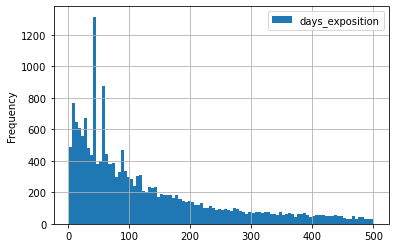

In [78]:
# Посмотрим, что там с частотой распределения
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,500));

Такое распределение характерно для данных с датой реализации (использования)

In [79]:
# посмотрим заполненные:
data_days_exposition = data[data['days_exposition'].notnull()][['days_exposition','first_day_exposition']]
data_days_exposition

,days_exposition,first_day_exposition
1,81.0,2018-12-04
2,558.0,2015-08-20
3,424.0,2015-07-24
4,121.0,2018-06-19
5,55.0,2018-09-10
...,...,...
23691,519.0,2016-10-13
23692,413.0,2017-07-07
23693,239.0,2016-08-05
23695,45.0,2018-01-15


In [80]:
data_days_exposition['year'] = data_days_exposition['first_day_exposition'].dt.year 
data_days_exposition['year'].value_counts().sort_values()

2014     119
2019    1083
2015    1121
2016    2716
2018    7560
2017    7919
Name: year, dtype: int64

Отмечается зависимость: совсем мало квартир проданы в 2014 году.

In [81]:
# посмотрим на незаполненные данные:
data_days_exposition_null = data[data['days_exposition'].isnull()][['days_exposition','first_day_exposition']]
data_days_exposition_null

,days_exposition,first_day_exposition
0,NaN,2019-03-07
7,NaN,2019-04-18
44,NaN,2018-11-18
45,NaN,2018-12-02
46,NaN,2019-01-31
...,...,...
23684,NaN,2018-11-02
23685,NaN,2019-01-24
23694,NaN,2017-03-21
23696,NaN,2018-02-11


In [82]:
data_days_exposition_null['year'] = data_days_exposition_null['first_day_exposition'].dt.year 
data_days_exposition_null['year'].value_counts().sort_values()

2014      18
2016      67
2015      70
2017     271
2018     959
2019    1796
Name: year, dtype: int64

Действительно, отмечается зависимость количества количеста дней нахождения объявления с годом.
В зависимости от цели задачи возможны различные варианты:
- не заполнять, это тоже приемлемый вариант
- заполнить срадним значением по старому году (например, по 2014)
- заполнить максимальным бакетом, который возможен (условно, за 36 месяцев все квартиры продаются). Этот вариант подохдит только для старых даты.

<br/>Учитывая это, здесь не будем заполнять указанные данные.

Вывод: произведена Предобработка данных, которая включала изучение данных, замену пропусков

In [83]:
# Теперь возможно заняться и дубликатами
# Посчитаем их
data.duplicated().sum()

0

<b> Выводы по разделу.</b>
<br/>Причины пропусков:
- общая площадь - нетп пропусков;
- жилая площадь - пропуски связаны с тем, что собственники не знали жилую площадь. Ее в дальнешем возможно, как долю от общей площади.
- площадь кухни - пропуски связаны с тем, что собственники не знали жилую площадь. Ее в дальнешем возможно, как долю от общей площади.
- цена объекта - нет пропусков. Это один из ключевых столбцов.
- количество комнат - нет пропусков
- высота потолков - высота потолков связана с неверными типами данных (скорее всего при конвертировании). Высота заменена снижением порядка.
- этаж квартиры - нет пропусков
- тип этажа квартиры («первый», «последний», «другой») - нет пропусков
- общее количество этажей в доме - предположение, что часть владельцев в объявлениях не знали количества этажей или посчитали это поле необязательным. Например, не знаю в доме 12 или 9 этажей.
- расстояние до центра города в метрах - маловероятно, что эти данные заполняли сами владельцы квартир. Ошибки могли связаны неверным заполнением объекта (по факту - отсутствием стандартизированного объекта)
- расстояние до ближайшего аэропорта - аналогично "расстояние до центра города в метрах"
- расстояние до ближайшего парка - аналогично "расстояние до центра города в метрах"
- день и месяц публикации объявления - на дату анализа не произошла реализация объекта недвижимости.

### Посчитайте и добавьте в таблицу новые столбцы

3.1 В задании: посчитано и добавлено в таблицу: цена одного квадратного метра

In [84]:
# разделим цену на момент снятия на общую площадь:
data['price_one_square_meter'] = round(data['last_price'] / data['total_area'], 1)

# проверим
data.price_one_square_meter.head()

0    120370.4
1     82920.8
2     92785.7
3    408176.1
4    100000.0
Name: price_one_square_meter, dtype: float64

In [85]:
data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter
23694,9,9700000.0,133.81,2017-03-21,3,3.700000,5.0,73.3,3,False,...,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72490.8
23695,14,3100000.0,59.00,2018-01-15,3,2.725502,5.0,38.0,4,False,...,0.0,Тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0,52542.4
23696,18,2500000.0,56.70,2018-02-11,2,2.725502,3.0,29.7,1,False,...,0.0,Село Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN,44091.7
23697,13,11475000.0,76.75,2017-03-28,2,3.000000,17.0,NaN,12,False,...,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,149511.4
23698,4,1350000.0,32.30,2017-07-21,1,2.500000,5.0,12.3,1,False,...,0.0,Поселок Новый Учхоз,NaN,NaN,0.0,NaN,0.0,NaN,NaN,41795.7


3.2 В задании: посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)

In [86]:
data['first_weekday_exposition'] = data['first_day_exposition'].dt.weekday # неделя
data['first_year_exposition'] = data['first_day_exposition'].dt.year       # год
data['first_month_exposition'] = data['first_day_exposition'].dt.month       # месяц

3.3 В задании: посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)

In [87]:
# Заполним первый этаж:

data.loc[data['floor'] == 1, 'type_floor'] = 'Первый'

# проверим:
data.query('type_floor == "Первый"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,first_weekday_exposition,first_year_exposition,first_month_exposition,type_floor
1,7,3350000.0,40.4,2018-12-04,1,2.725502,11.0,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,82920.8,1,2018,12,Первый
14,1,4400000.0,36.0,2016-06-23,1,2.725502,6.0,17.0,1,False,...,0.0,NaN,1.0,96.0,203.0,122222.2,3,2016,6,Первый
16,11,6700000.0,82.0,2017-11-23,3,3.050000,5.0,55.6,1,False,...,3.0,420.0,0.0,NaN,397.0,81707.3,3,2017,11,Первый
24,8,6500000.0,97.2,2015-10-31,2,2.725502,3.0,46.5,1,False,...,3.0,411.0,3.0,124.0,265.0,66872.4,5,2015,10,Первый
28,8,4170000.0,44.0,2017-12-13,1,2.900000,6.0,20.8,1,False,...,0.0,NaN,1.0,118.0,74.0,94772.7,2,2017,12,Первый
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23665,11,4250000.0,47.0,2016-05-20,1,2.725502,6.0,18.2,1,False,...,2.0,624.0,1.0,519.0,131.0,90425.5,4,2016,5,Первый
23673,9,3100000.0,23.0,2018-03-19,1,2.800000,9.0,12.6,1,False,...,1.0,262.0,1.0,442.0,41.0,134782.6,0,2018,3,Первый
23680,14,5000000.0,59.0,2019-04-04,3,2.500000,5.0,52.0,1,False,...,0.0,NaN,0.0,NaN,NaN,84745.8,3,2019,4,Первый
23696,18,2500000.0,56.7,2018-02-11,2,2.725502,3.0,29.7,1,False,...,0.0,NaN,0.0,NaN,NaN,44091.7,6,2018,2,Первый


In [88]:
# Заполним последний этаж:
data.loc[data['floor'] == data['floors_total'], 'type_floor'] = 'Последний'

# проверим:
data.query('type_floor == "Последний"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,first_weekday_exposition,first_year_exposition,first_month_exposition,type_floor
12,10,3890000.0,54.0,2016-06-30,2,2.725502,5.0,30.0,5,False,...,0.0,NaN,0.0,NaN,90.0,72037.0,3,2016,6,Последний
13,20,3550000.0,42.8,2017-07-01,2,2.560000,5.0,27.0,5,False,...,1.0,294.0,3.0,298.0,366.0,82943.9,5,2017,7,Последний
23,11,2950000.0,32.0,2016-10-29,1,2.600000,9.0,17.7,9,False,...,2.0,517.0,1.0,190.0,615.0,92187.5,5,2016,10,Последний
36,13,3790000.0,45.0,2017-01-25,2,2.725502,9.0,27.0,9,False,...,1.0,459.0,0.0,NaN,139.0,84222.2,2,2017,1,Последний
43,13,9330000.0,48.0,2017-01-10,2,3.000000,4.0,28.0,4,False,...,0.0,NaN,1.0,492.0,763.0,194375.0,1,2017,1,Последний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23641,3,3100000.0,30.0,2018-03-28,1,2.500000,5.0,17.0,5,False,...,0.0,NaN,0.0,NaN,10.0,103333.3,2,2018,3,Последний
23644,7,4990000.0,62.5,2018-04-26,2,2.700000,4.0,32.3,4,False,...,1.0,560.0,1.0,171.0,166.0,79840.0,3,2018,4,Последний
23648,14,10100000.0,78.0,2017-05-12,3,3.270000,5.0,48.6,5,False,...,1.0,621.0,2.0,117.0,621.0,129487.2,4,2017,5,Последний
23660,1,2950000.0,53.6,2018-02-01,2,2.750000,3.0,32.0,3,False,...,0.0,NaN,0.0,NaN,35.0,55037.3,3,2018,2,Последний


In [89]:
# Заполним Другой этаж:

data.type_floor = data.type_floor.fillna('Другой')

# проверим:
data.query('type_floor == "Другой"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,first_weekday_exposition,first_year_exposition,first_month_exposition,type_floor
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120370.4,3,2019,3,Другой
2,10,5196000.0,56.00,2015-08-20,2,2.725502,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92785.7,3,2015,8,Другой
3,0,64900000.0,159.00,2015-07-24,3,2.725502,14.0,NaN,9,False,...,2.0,84.0,3.0,234.0,424.0,408176.1,4,2015,7,Другой
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14.0,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,100000.0,1,2018,6,Другой
5,10,2890000.0,30.40,2018-09-10,1,2.725502,12.0,14.4,5,False,...,0.0,NaN,0.0,NaN,55.0,95065.8,0,2018,9,Другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1350000.0,30.00,2017-07-07,1,2.725502,5.0,17.5,4,False,...,0.0,NaN,0.0,NaN,413.0,45000.0,4,2017,7,Другой
23693,9,4600000.0,62.40,2016-08-05,3,2.600000,9.0,40.0,8,False,...,1.0,352.0,1.0,675.0,239.0,73717.9,4,2016,8,Другой
23694,9,9700000.0,133.81,2017-03-21,3,3.700000,5.0,73.3,3,False,...,1.0,796.0,3.0,381.0,NaN,72490.8,1,2017,3,Другой
23695,14,3100000.0,59.00,2018-01-15,3,2.725502,5.0,38.0,4,False,...,0.0,NaN,0.0,NaN,45.0,52542.4,0,2018,1,Другой


3.4 в задании: посчитано и добавлено в таблицу: расстояние в км до центра города

In [90]:
# посчитаем
data['to_center_km'] = (data['city_centers_nearest'] / 1000).round()

# и проверим
data['to_center_km'].head()

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: to_center_km, dtype: float64

### Проведите исследовательский анализ данных

Изучение параметров квартиры:
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - этаж квартиры;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего аэропорта;
  - расстояние до ближайшего парка;
  - день и месяц публикации объявления

4.1 Изучение параметров квартиры - Общая площадь

In [91]:
# общая площадь:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

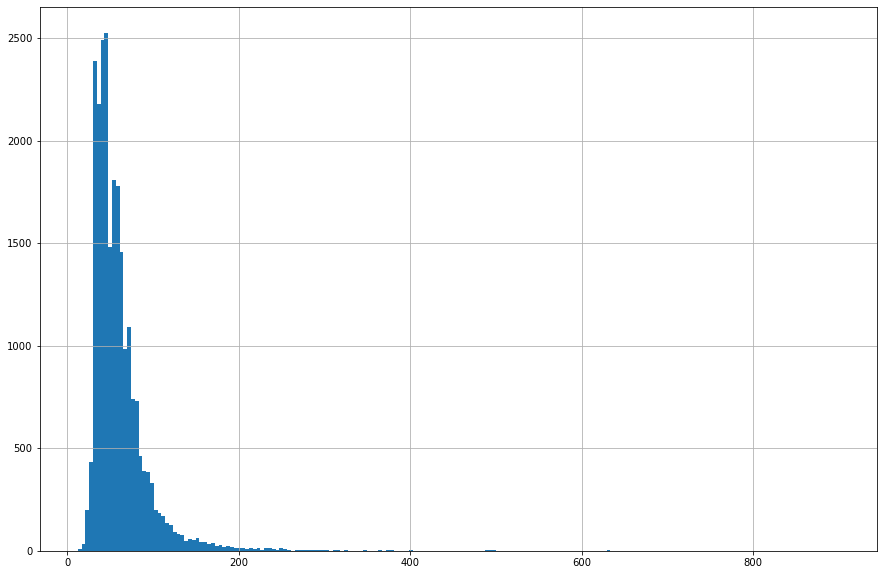

In [92]:
data['total_area'].hist(bins=200, figsize=(15, 10));

распределение сконцентрирована в интервале с 30-200 метров. Остальные значения явялеются выбросами

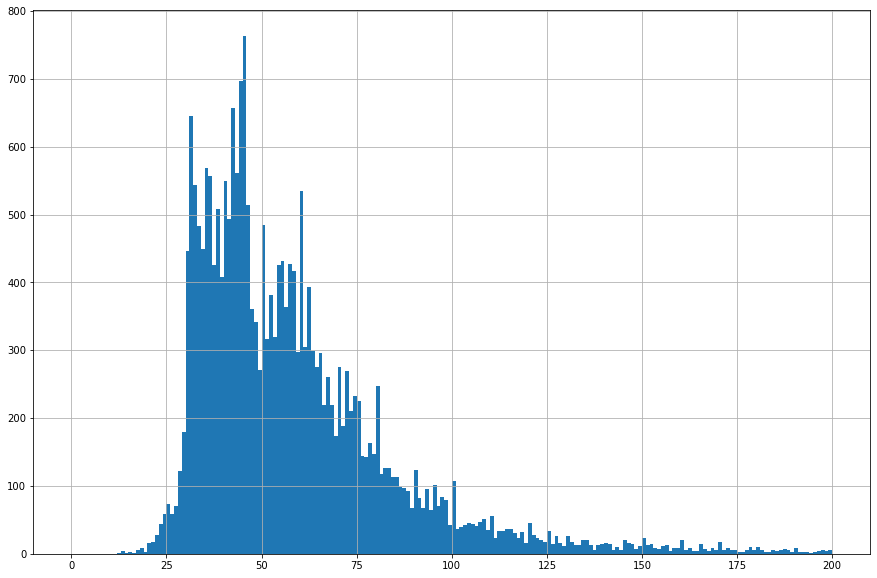

In [93]:
# посмотрим более подробно интервал 0-200
data['total_area'].hist(bins=200, figsize=(15, 10), range=(0, 200));

разброс от 25 до 100. Это похоже на правду. Остальное выбросы.

4.2  Изучение параметров квартиры - Жилая площадь

In [94]:
# общая информация
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

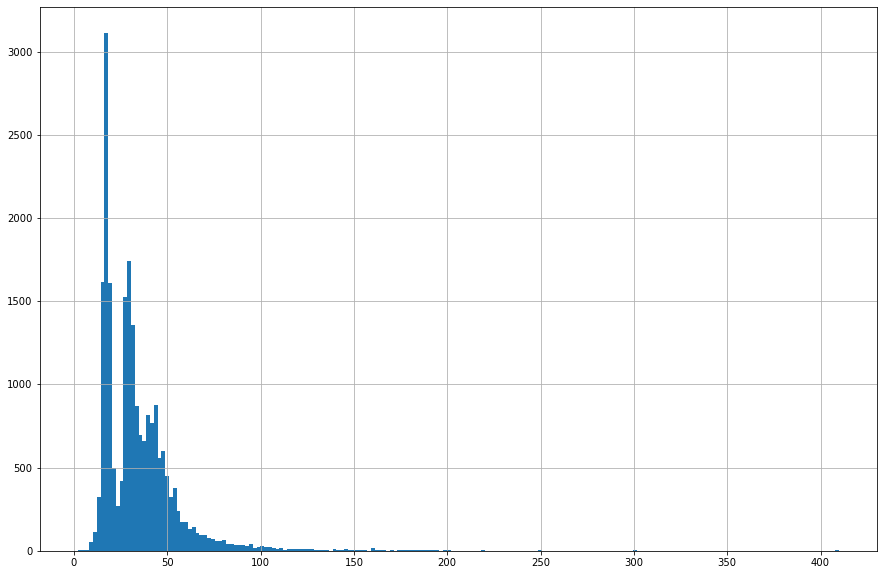

In [95]:
# плотность жилой площади
data['living_area'].hist(bins=200, figsize=(15, 10));

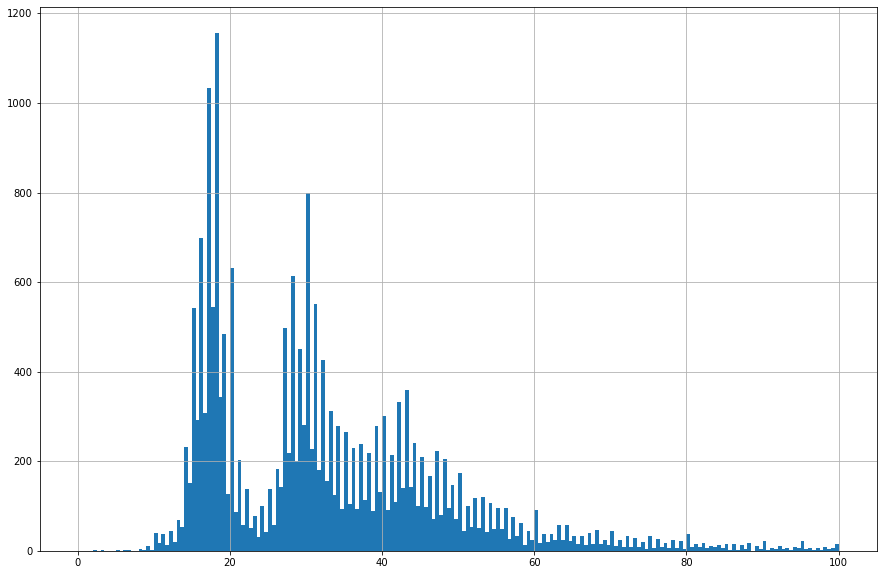

In [96]:
# посмотрим от 0 до 100:
data['living_area'].hist(bins=200, figsize=(15, 10), range=(0, 100));

наибольшее количество - 18 м2 жилой площади

4.3  Изучение параметров квартиры - площадь кухни

In [97]:
data['kitchen_area'].describe()

count    23699.000000
mean        10.463176
std          6.027630
min          0.865913
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

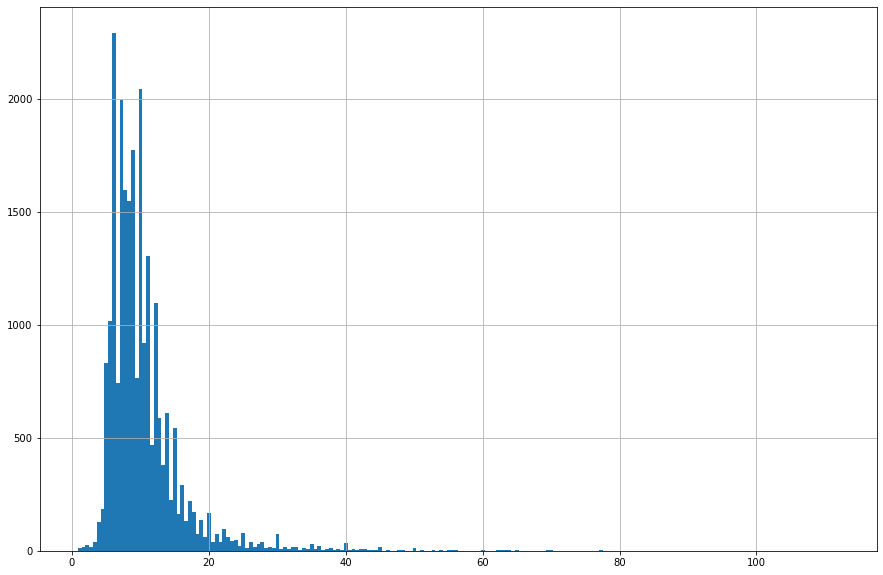

In [98]:
# построим распределение площади кухни:
data['kitchen_area'].hist(bins=200, figsize=(15, 10));

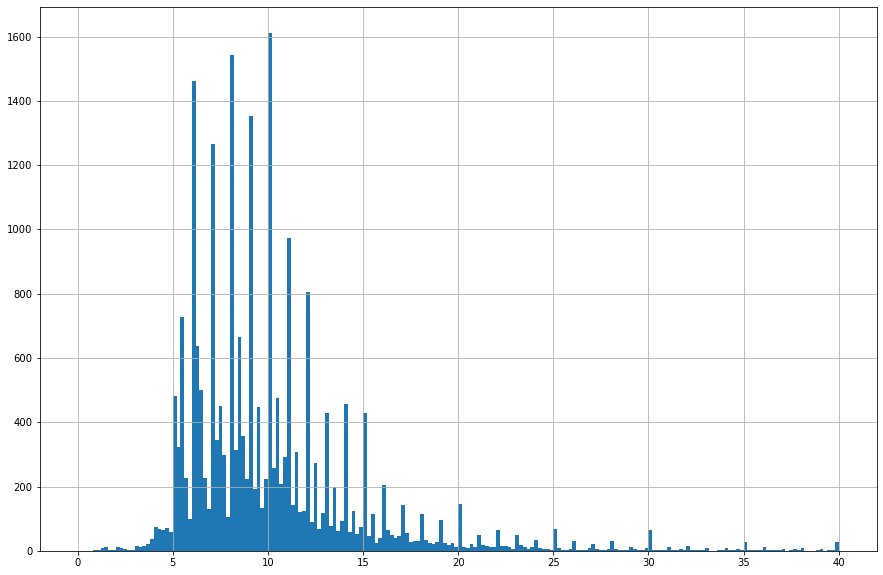

In [99]:
# более детально на интервале 0-40 метро2
data['kitchen_area'].hist(bins=200, figsize=(15, 10), range=(0, 40));

Самая частая кухня имеет размер 11м2. Выше 20 уже зажиточно. Или аномально.

4.4  Изучение параметров квартиры - цена объекта

In [100]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

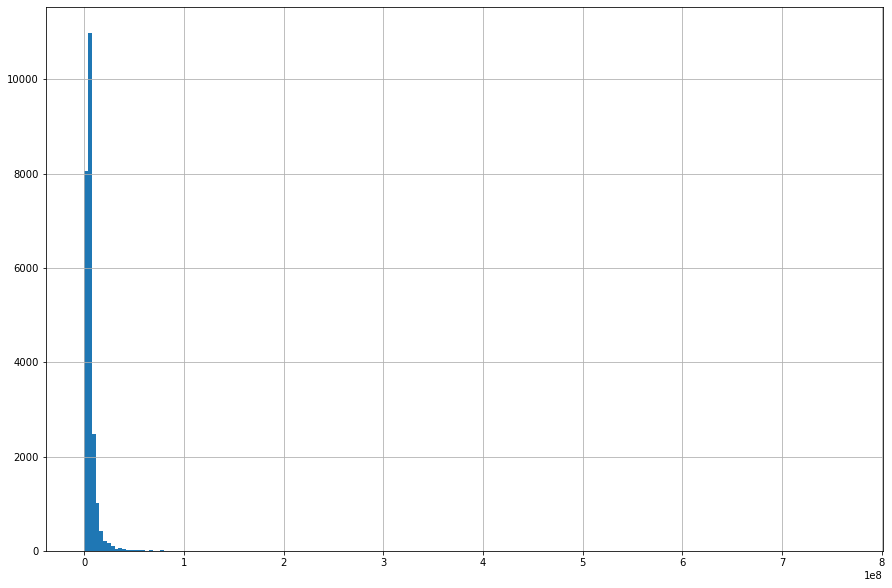

In [101]:
data['last_price'].hist(bins=200, figsize=(15, 10));

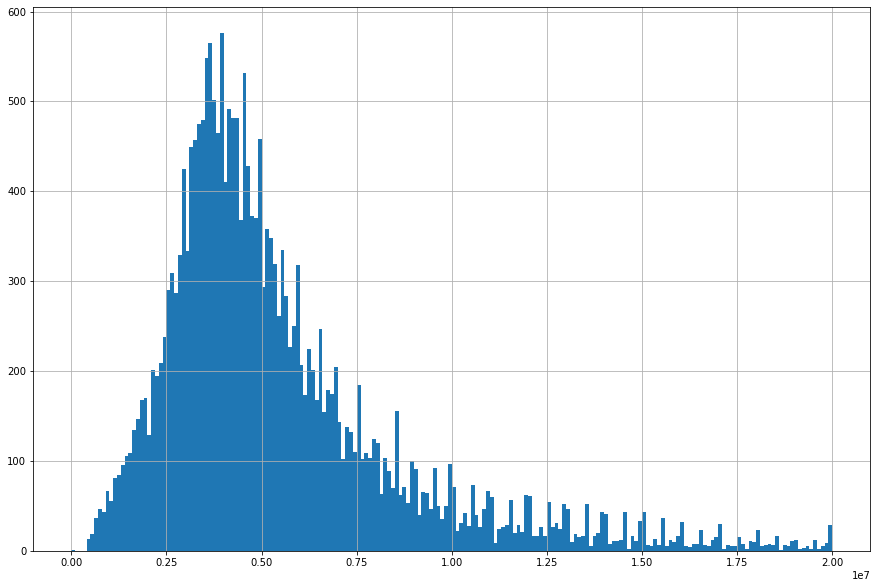

In [102]:
data['last_price'].hist(bins=200, figsize=(15, 10), range=(0, 20000000)); # , sharey: bool = False,

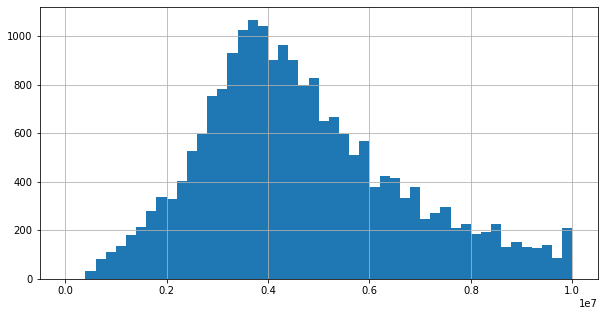

In [103]:
data['last_price'].hist(bins=50, figsize=(10, 5), range=(0, 10000000)); # , sharey: bool = False,

В данном случае аномалиями являеются квартиры, которые превышают стоимость 20 млн. руб.

4.5  Изучение параметров квартиры - rooms

In [104]:
data['rooms'].describe()

count    23699.000000
mean         2.078948
std          1.066196
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

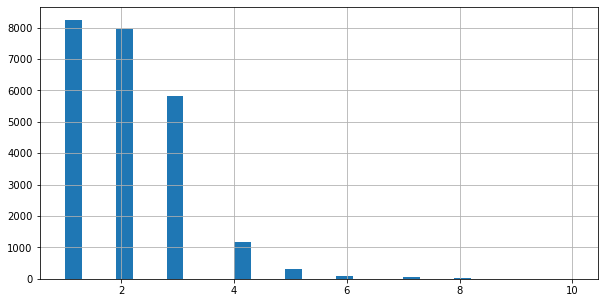

In [105]:
data['rooms'].hist(bins=30, figsize=(10, 5), range=(1, 10));

Здесь все видно с первого раза. Свыше 5 комнат - аномально. Самые частовстречающиеся - однушки.

4.6  Изучение параметров квартиры - высота потолков

In [106]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.725502
std          0.210683
min          2.000000
25%          2.600000
50%          2.725502
75%          2.725502
max          4.000000
Name: ceiling_height, dtype: float64

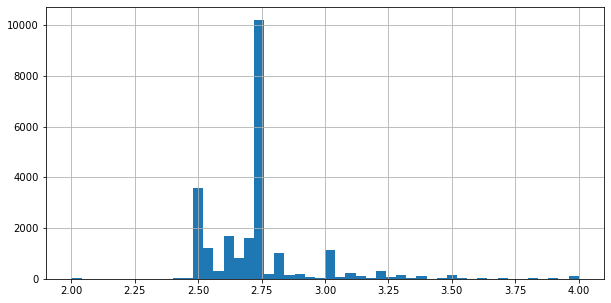

In [107]:
data['ceiling_height'].hist(bins=50, figsize=(10, 5));

Здесь разброс от 2 до 4 метров. Наиболее распространенная высота 2,7 м.

4.7 Изучение параметров квартиры - этаж квартиры

In [108]:
data['floor'].describe()

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

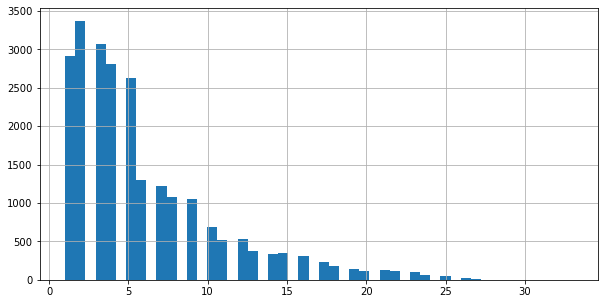

In [109]:
data['floor'].hist(bins=50, figsize=(10, 5));

Вот! здедсь тоже все наглядно.Свыше 25 уже аномалии. Можно увидеть разницу между 5 и 6 этажем. Это сказывается, что ранее были типовые дома по 5 этажей.
Самый популярный этаж - второй.

4.8 Изучение параметров квартиры - тип этажа квартиры

In [110]:
data['type_floor'].describe()

count      23699
unique         3
top       Другой
freq       17441
Name: type_floor, dtype: object

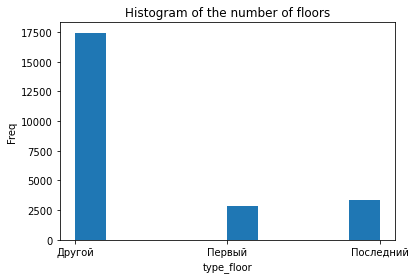

In [111]:
plt.hist(data['type_floor'])
plt.title('Histogram of the number of floors')
plt.xlabel('type_floor')
plt.ylabel('Freq')
plt.show()

Здесь подтверждается функция describe, что наиболее популярным явялется этаж отличный от первого и последнего.

4.9 Изучение параметров квартиры - общее количество этажей в доме

In [112]:
data['floors_total'].describe()

count    23662.000000
mean        10.670358
std          6.590778
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

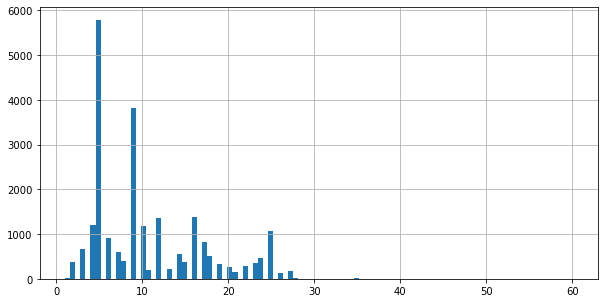

In [113]:
# посмотрим частону
data['floors_total'].hist(bins=100, figsize=(10, 5));

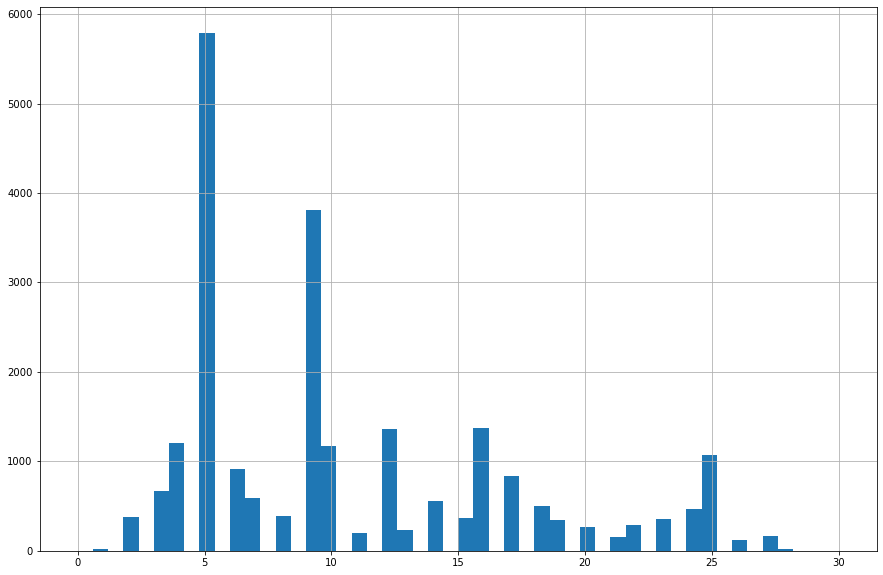

In [114]:
# более подробно:
data['floors_total'].hist(bins=50, figsize=(15, 10), range=(0, 30));

Здесь подтверждается, что наиболее часто встречаемые дома - пятиэтажки и девятиэтажки. Потом идут по 12 и 16 этажей.

4.10 Изучение параметров квартиры - расстояние до центра города в метрах

In [115]:
data['city_centers_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

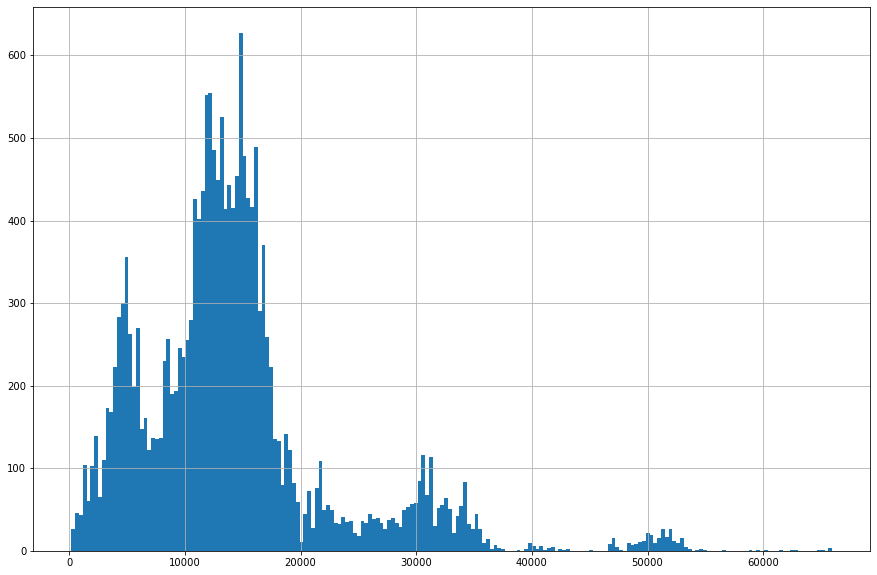

In [116]:
# посмотрим на распределение
data['city_centers_nearest'].hist(bins=200, figsize=(15, 10));

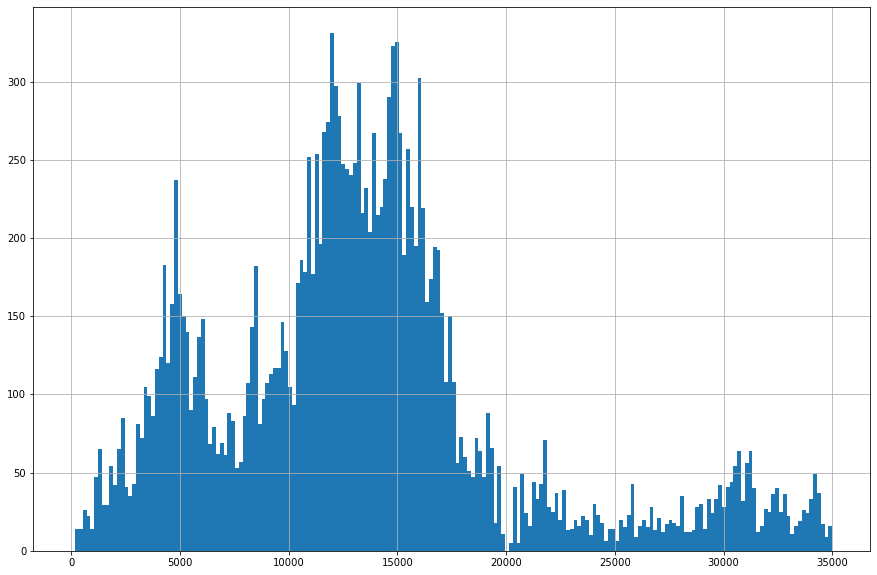

In [117]:
# более наглядно
data['city_centers_nearest'].hist(bins=200, figsize=(15, 10), range=(0, 35000));

Здесь виды города (районы) - пики. Самый густопостроенный район находится в 12 км от центра.

4.11 Изучение параметров квартиры - расстояние до ближайшего аэропорта

In [118]:
data['airports_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

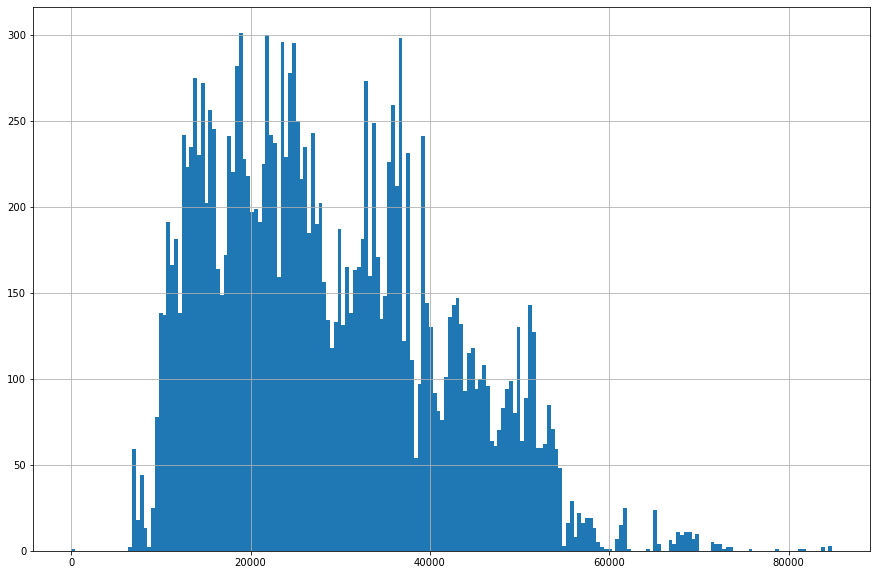

In [119]:
data['airports_nearest'].hist(bins=200, figsize=(15, 10));

Можно сделать выводы, что выбросы после 60 км и до 9 км до аэропорта.

4.12 Изучение параметров квартиры - расстояние до ближайшего парка

In [120]:
data['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

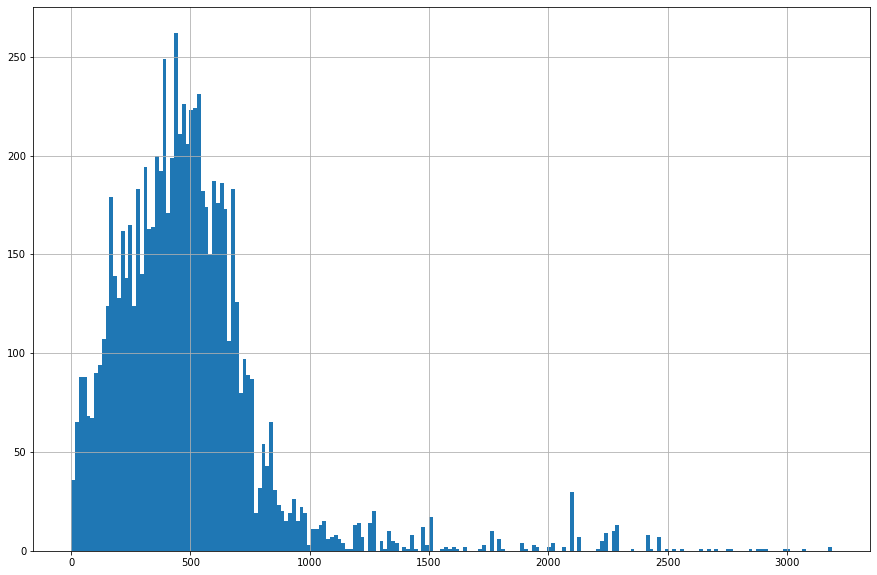

In [121]:
# распределение
data['parks_nearest'].hist(bins=200, figsize=(15, 10));

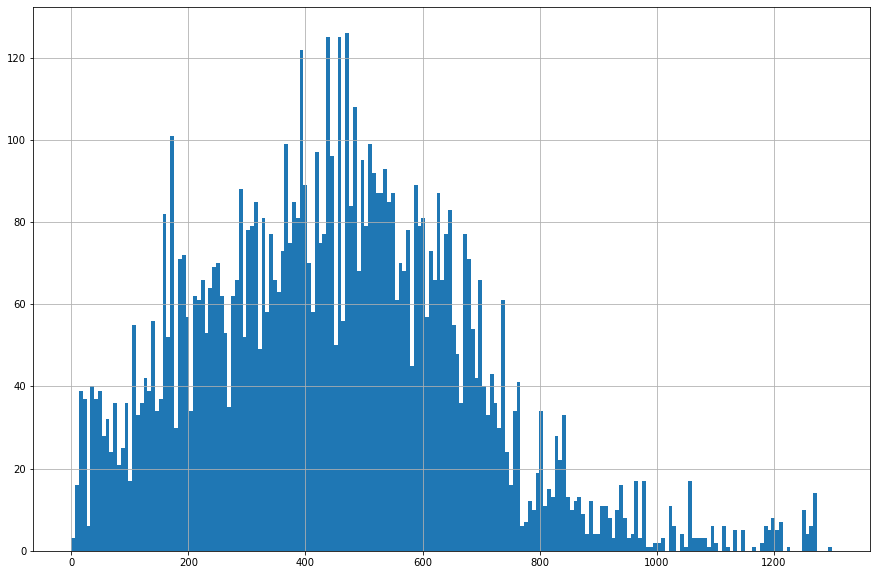

In [122]:
# более наглядно
data['parks_nearest'].hist(bins=200, figsize=(15, 10), range=(0, 1300));

Чаще всего квартиры находятся в 420 метров от парка.

4.13 Изучение параметров квартиры - день

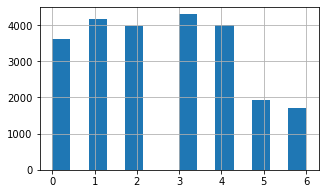

In [123]:
# полагаю, что здесь имелось ввиду день недели, а не число.
data['first_weekday_exposition'].hist(bins=14, figsize=(5, 3));

Чаще всего размещают объявления в будник. Субботу и воскресенье размещают в два раза меньше.

4.14 Изучение параметров квартиры - месяц

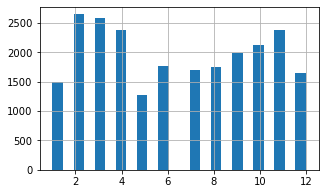

In [124]:
data['first_month_exposition'].hist(bins=24, figsize=(5, 3));

Можно сделать вывод, что в Декабре, Январе, Мае редкие размещения. Проослеживается воможная связь между занятостью населения.

<b>Доп задание 1.
<br>Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.

In [125]:
data.days_exposition.describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

В среднем квартира реализовывалась за 180 дней. Здесь конечно необходимо понимать процесс получения данных. 
Возможно объявления покупаются на определенный срок, а квартира не продалась.

In [126]:
# еще раз расчитаем среднее:
print('Сраднее арифметическое: ', data.days_exposition.mean())

#и медиану
print('Медианное значение: ', data.days_exposition.median())

Сраднее арифметическое:  180.88863436982163
Медианное значение:  95.0


In [127]:
# посмотрим это все же по новым данным
data.days_exposition.describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

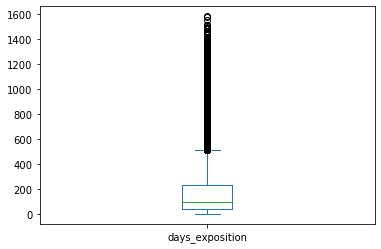

In [128]:
# Задании не встречался ящик с усами, поэтому построим его здесь.
data['days_exposition'].plot(kind = 'box');

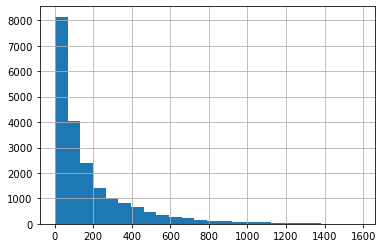

In [129]:
# выведем соответствующую гистограмму по плотности распределения:
data['days_exposition'].hist(bins=24, figsize=(6, 4));

Отлично. Box-плот сходится с гистограммой.

<b>Вывод:</b> Среднее значение продаж квартир составляет 180 дней. Медиана "сдвинута" на 95 дней. Очень быстрими считаются продажи до 45 дней, поздними 232 и более.

Доп. задание 2
Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.
  - общей площади;
  - жилой площади;
  - площади кухни;
  - количество комнат;
  - типа этажа, на котором расположена квартира (первый, последний, другой);
  - даты размещения (день недели, месяц, год);

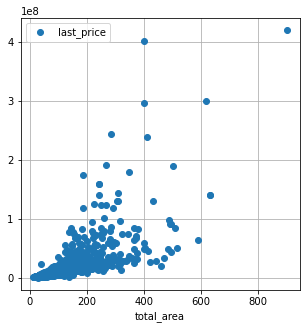

correlation matrix:
            last_price  total_area
last_price    1.000000    0.738972
total_area    0.738972    1.000000


In [130]:
# Построим матрицу корреляции по каждой переменной от last_price

(
    data.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()

print('correlation matrix:')
print(data.pivot_table(index='floor', values=['total_area', 'last_price']).corr())

Общая площадь имеет прямую корреляцию с итоговой ценой - 0,7389. Ее можно оценить как высокая!

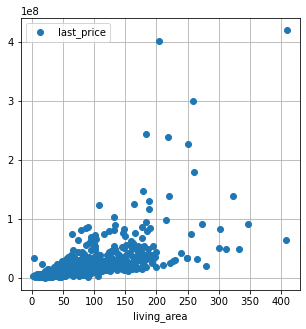

correlation matrix:
             last_price  living_area
last_price     1.000000     0.655849
living_area    0.655849     1.000000


In [131]:
# жилая площадь

(
    data.pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()

print('correlation matrix:')
print(data.pivot_table(index='floor', values=['living_area', 'last_price']).corr())

общая площадь имеет прямую корреляцию с итоговой ценой - 0.6558. Но она менее общей площади.

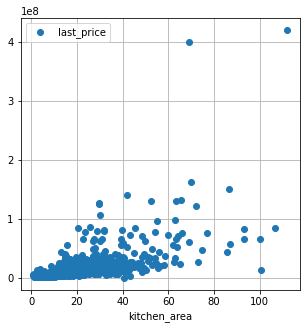

correlation matrix:
              kitchen_area  last_price
kitchen_area      1.000000    0.289172
last_price        0.289172    1.000000


In [132]:
# площадь кухни

(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()

print('correlation matrix:')
print(data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr())

Площадь кухни почти не имеется корреляция с общей стоимостью.

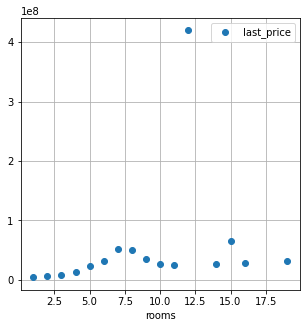

correlation matrix:
            last_price     rooms
last_price    1.000000  0.444264
rooms         0.444264  1.000000


In [133]:
# количество комант
(
    data.pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()

print('correlation matrix:')
print(data.pivot_table(index='floor', values=['rooms', 'last_price']).corr())

Здесь отмечается низкая корреляция. Также есть сильный выброс.

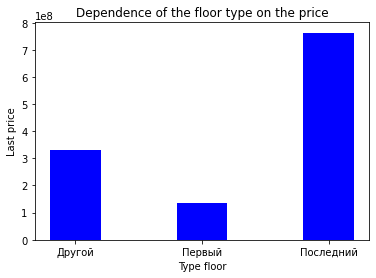

In [134]:
# типу этажа (type_floor)
plt.bar(data.type_floor, 
        data.last_price,
        color ='blue',
        width = 0.4)
 
plt.xlabel("Type floor")
plt.ylabel("Last price")
plt.title("Dependence of the floor type on the price")
plt.show()

Можно сделать вывод, что первый этаж не в почете. А последний самый частый.

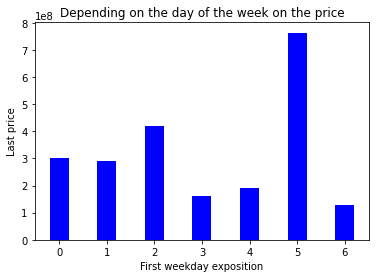

In [135]:
# дню недели (first_weekday_exposition)
plt.bar(data.first_weekday_exposition, 
        data.last_price,
        color ='blue',
        width = 0.4)
 
plt.xlabel("First weekday exposition")
plt.ylabel("Last price")
plt.title("Depending on the day of the week on the price")
plt.show()

Если рассматривать дни недели, то здесь выделяется суббота.

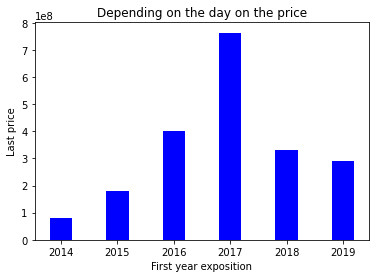

In [136]:
# по году  (first_year_exposition)
plt.bar(data.first_year_exposition, 
        data.last_price,
        color ='blue',
        width = 0.4)
 
plt.xlabel("First year exposition")
plt.ylabel("Last price")
plt.title("Depending on the day on the price")
plt.show()

Здесь наибольшее значение принимает 2017 год

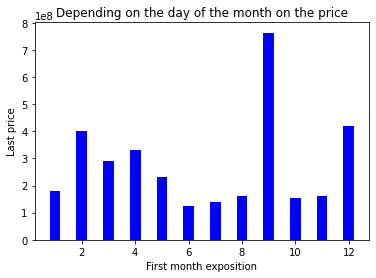

In [137]:
# по месяцу  (first_month_exposition)
plt.bar(data.first_month_exposition, 
        data.last_price,
        color ='blue',
        width = 0.4)
 
plt.xlabel("First month exposition")
plt.ylabel("Last price")
plt.title("Depending on the day of the month on the price")
plt.show()

Здесь сентябрь принимает макимальное значение.

Доп. задание 3. 
Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [138]:
# в сводной таблице посмотрим количество объявлений в каждом населенном пункте (локалити_нейм)
top_locality_name = data.pivot_table(index='locality_name', values='price_one_square_meter', aggfunc=['count', 'mean'])
top_locality_name.columns = ['count', 'mean']
top_locality_name = top_locality_name.sort_values(by='count', ascending=False)[:10]
top_locality_name = top_locality_name.sort_values(by='mean', ascending=False)
top_locality_name

,count,mean
locality_name,,
Санкт-Петербург,15721,114849.008956
Пушкин,369,103125.818157
Деревня Кудрово,299,92473.546488
Поселок Парголово,327,90175.915291
Поселок Мурино,556,85681.761691
Поселок Шушары,440,78677.363636
Колпино,338,75424.581953
Гатчина,307,68746.147231
Всеволожск,398,68654.475628


Больше всего объявлений в Санкт-Питербурге. В нем же самая большая средняя цена. По средней стоимости замыкает десятку Выборг.

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."

In [139]:
data_piter = data[data['locality_name'] == 'Санкт-Петербург']
data_piter.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,first_weekday_exposition,first_year_exposition,first_month_exposition,type_floor,to_center_km
0,20,13000000.0,108.0,2019-03-07,3,2.700000,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.4,3,2019,3,Другой,16.0
2,10,5196000.0,56.0,2015-08-20,2,2.725502,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.7,3,2015,8,Другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.725502,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.1,4,2015,7,Другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.030000,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.0,1,2018,6,Другой,8.0
7,5,7915000.0,71.6,2019-04-18,2,2.725502,24.0,NaN,22,False,...,NaN,0.0,NaN,NaN,110544.7,3,2019,4,Другой,12.0


In [140]:
# сделаем сводную таблицу:

piter_center_nearest = data_piter.pivot_table(index='to_center_km', values=['price_one_square_meter', 'last_price'], aggfunc='median')

piter_center_nearest.head(10)

,last_price,price_one_square_meter
to_center_km,,
0.0,17900000.0,172619.00
1.0,11395000.0,128485.10
2.0,10000000.0,123035.50
3.0,8409000.0,108469.10
4.0,9200000.0,117952.30
5.0,9500000.0,127093.25
6.0,8900000.0,131835.25
7.0,7800000.0,127017.10
8.0,7450000.0,122944.90


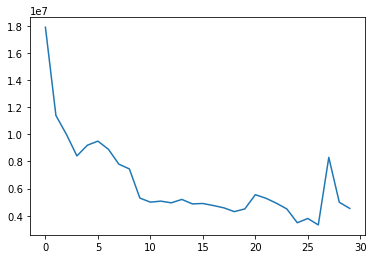

In [141]:
# зависимость цены от удаленности от центра
plt.plot(piter_center_nearest.index, piter_center_nearest.last_price)
plt.show()

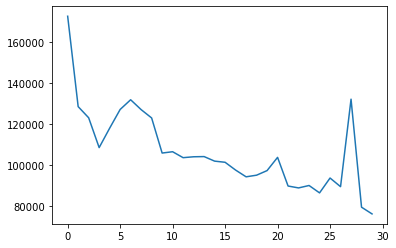

In [142]:
# зависимость удельной цены (за квадратный метр) от удаленности от центра
plt.plot(piter_center_nearest.index, piter_center_nearest.price_one_square_meter)
plt.show()

Замента значительная разница между квартрами, которые находятся в центре (0 км от центра). Всего 172 тыс. руб.
Остальные квартиры стоят примерно одинаково (равномерно снижаюся).

Вывод: произведен исследовательский анализ данных, по которому можно сделать выводы:
- Чаще всего размещают объявления в будни. Субботу и воскресенье размещают в два раза меньше.
- В Декабре, Январе, Мае редкие размещения. Проослеживается воможная связь между занятостью населения.
- В среднем квартиры продаются за 180 дней. Очень редко до 45 дней или свыше 200
- наибольшую корреляцию с ценой продажи имеет площадь квартиры
- Самая дорогая стоимость во Всеволжске Ленинградской области
- В городе Санкт-Питербург в центре квартиры стоят по 172 тыс. руб. за кв. местр. А через киломентр уже ниже. Историческая часть.

### Общий вывод

В работе в датасете недвижимости произведены:
- Проведен анализ данных. Проверена корректность всех столбцов дата-сета.
- В данных (столцах), где возможно, были восстановлены данные (заменены пропуски). Также дополнительно произведена корректировка значений, которые не являются логичными: 1-этаж квартиры выше, чем колиество этажей в этом же доме, 2 - общая площадь квартиры меньше, чем сумма ее комнат (зон).
- ОТдельно проанализирован срок реализации. Средний срок реализации составляет 180 дней. Разрос по квантилям находится в интервале от 45 до 232 дней.
- Проанализрована зависимость от стоимости по различным показателям: Минимальная стоимость у первых этажей, максимальная в размещенных в субботу, самый дорогой был 2017 год, в сентябре самая высокая цена.
- Больше всего объявлений в Санкт-Питербурге. При этом цена в этом городе на квартиры в два раза выше, чем несколько километров от центра. В горячей десятке самые дешевые квартиры находятся в Выборге.